## 7 一般化線形混合モデル(GLMM)
実際のデータでは、説明変数が同じであれば平均も同じというGLMの仮定が成り立たない。  
これは、データにばらつきをもたらす「個体間の差異」を定量化できないことが要因である。  
このような「人間が測定できない・測定しなかった個体差」を組み込んだGLMである、**一般化線形混合モデル(GLMM)**を説明する。  
これは、データのばらつきは二項分布・ポアソン分布で、個体のばらつきは正規分布で表すような、  
複数の確率分布を部品とする統計モデルである。  
個体差・場所差は、観測者がデータ化していないが個体や調査地に由来する原因不明の差を表す。  
観測されてデータになっている個体の属性、つまり統計モデルの説明変数として使える数量・因子は個体差とは呼ばない。   
  
### 7.1 GLMでは説明できないカウントデータ
架空植物のデータを使用する。  
個体数は100で、個体$i$ごとの調査種子数は8個、そのうち生存していた種子数は$y_i$個である。  
種子の生存確率が、個体ごとに異なる葉数$x_i$に依存していることにする。

In [3]:
import pandas as pd

d = pd.read_csv('C:/Users/tanak/study/参考書/データ解析のための統計モデリング/kubobook_2012/glmm/data.csv')
d.head()

,N,y,x,id
0,8,0,2,1
1,8,1,2,2
2,8,2,2,3
3,8,4,2,4
4,8,1,2,5


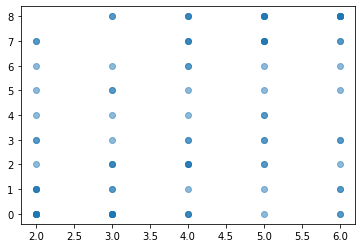

In [8]:
import matplotlib.pyplot as plt

plt.scatter(d.x, d.y, alpha=.5);

線形予測子とロジットリンク関数を組み合わせて、  
個体$i$での種子の生存確率$q_i$が葉数$x_i$に依存するようにする。
$$
logit(q_i)=\beta_1+\beta_2x_i
$$

観測された生存種子数が$y_i$である確率が二項分布に従うとすると、
$$
p(y_i|\beta_1,\beta_2)=
\begin{pmatrix}
8\\
y_i
\end{pmatrix}
q_i^{y_i}(1-q_i)^{8-y_i}
$$

対数尤度は、
$$
\log{L}=\sum_i\log{p(y_i|\beta_1,\beta_2)}
$$

となる。

In [13]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

# 応答変数は(生存数, 死亡数)であり、I()を使って表現
model = smf.glm(formula='y + I(N - y) ~ x', data=d, family=sm.families.Binomial())
results = model.fit(disp=0)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      ['y', 'I(N - y)']   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -322.80
Date:                Wed, 20 Oct 2021   Deviance:                       513.84
Time:                        19:47:57   Pearson chi2:                     428.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.1487      0.237     -9.057      0.000      -2.614      -1.684
x              0.5104      0.056      9.179      0.000       0.401       0.619
==============================================================================
"""

In [30]:
import numpy as np
from scipy.stats import binom

def logistic(z):
    return 1 / (1 + np.exp(-z))

pred = lambda x: results.params[0] + results.params[1] * x

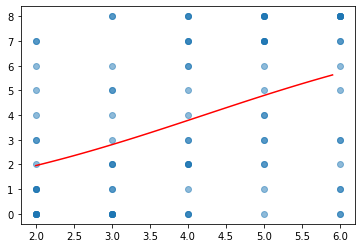

In [55]:
x = np.arange(2, 6, 0.1)

plt.scatter(d.x, d.y, alpha=.5);
plt.plot(x, logistic(pred(x))*8, color='red');

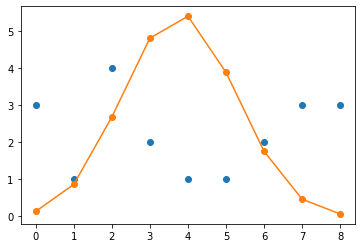

In [76]:
y = np.arange(0, 9)

dx4 = d[d.x==4].groupby(['y'])['N'].count().reset_index()
predx4 = binom.pmf(k=y, n=8, p=logistic(pred(4)))*np.sum(dx4.N)

plt.plot(dx4.y, dx4.N, 'o');
plt.plot(y, predx4, '-o');

$x_i=4$であるときの20個体の生存種子数を見ると、二項分布に従っているようには見えない。

### 7.2 過分散と個体差
ばらつきが二項分布で説明できないにもかかわらず、二項分布であると仮定したモデルをあてはめたため正しい推定値が得られなかった。  
このように二項分布で期待されるよりも大きなばらつきを**過分散**と呼ぶ。

In [99]:
d4 = d[d.x==4]

print('mean:', np.mean(d4.y), 'var: ', np.var(d4.y, ddof=1))

p = np.mean(d4.y)/8

# 二項分布に従ったとしたときの期待される分散
print(8*p*(1-p))

mean: 4.05 var:  8.365789473684211
1.9996875


期待される分散よりも4倍ほど大きくなっている(過分散)。  
このデータは二項分布と呼ぶには「ばらつきが大きすぎる」ので二項分布を使って説明できない。  
  
原因の一つとして、観測されていない個体差が挙げられる。  
観測されていない個体差とは今回の場合、少なくとも2種類考えられる。  
ひとつは、生物的な要因であり、たとえば個体の遺伝子、年齢や過去に経験した履歴の相違などである。  
もうひとつは、局所的な栄養塩類量や水分環境・光環境が異なるといった生育環境の微妙な違いなどが挙げられる。  
ここでは、非生物的な局所環境の影響のことを場所差あるいはブロック差と呼ぶこととする。  
観測者はこの架空植物に影響を与えている要因をすべて定量・特定することは不可能である。  
個体差や場所差を原因不明のまま、これらの影響をうまくとりこんだ統計モデルが必要になる。

### 7.3 一般化線形混合モデル(GLMM)
GLMMは個体差や場所差の効果をGLMにくみこんだ統計モデルである。  
#### 個体差をあらわすパラメータの追加
架空植物の種子の生存確率$q_i$を表す式に、個体$i$の個体差を表すパラメータ$r_i$を追加する。
$$
logit(q_i)=\beta_1+\beta_2x_i+r_i
$$

$r_i$は$-\infty$から$+\infty$をとる連続値である。  
 

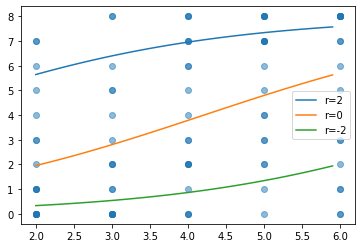

In [105]:
pred_r = lambda x, r: results.params[0] + results.params[1] * x + r

x = np.arange(2, 6, 0.1)

plt.scatter(d.x, d.y, alpha=.5);
for r in [2,0,-2]:
    plt.plot(x, logistic(pred_r(x, r))*8, label="r="+str(r));
plt.legend();

#### 個体差のばらつきをあらわす確率分布
GLMMの特徴は、個体差をあらわすパラメータ$\{r_1,r_2,\cdots,r_{100} \}$が何らかの確率分布にしたがっていると仮定するところである。  
ここではとりあえず、個体差$r_i$平均ゼロで標準偏差$s$の正規分布にしたがうと仮定する。  
ただし、そもそも$r_i$は観測できなかった量なので、正規分布である根拠は何もない。  
  
確率密度関数は$p(r_i|s)$は以下のようになる。
$$
p(r_i|s)=\frac{1}{\sqrt{2\pi s^2}}\exp{\biggl(-\frac{r_i^2}{2s^2} \biggr)}
$$

$r_i=0$付近で$p(r_i|s)$が高くなっているので、$r_i$がゼロに近い個体はありがちで、大きな個体はあまりないことを表す。  
標準偏差$s$が大きければ個体差の大きい集団であり、$s$が小さければ個体差の小さな集団と表現できる。  
個体差のばらつき$s$が大きいほど、過分散がひどくなりそうだとわかる。

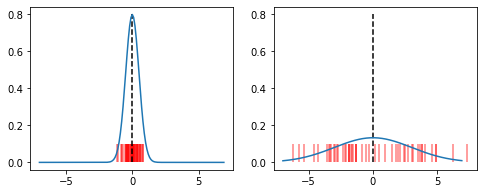

In [131]:
from scipy.stats import norm

s_small = np.random.normal(loc = 0, scale = 0.5, size  = 50)
s_large = np.random.normal(loc = 0, scale = 3.0, size  = 50)

x = np.arange(-7, 7, 0.1)
y_small = norm.pdf(x, loc=0, scale=0.5)
y_large = norm.pdf(x, loc=0, scale=3.0)

fig ,axes = plt.subplots(nrows=1, ncols=2, figsize=(4*2, 3))

axes[0].vlines(s_small, 0, 0.1, alpha=.5, color="red");
axes[0].vlines(0, 0, 0.8, color="black", linestyle='--');
axes[0].plot(x, y_small);

axes[1].vlines(s_large, 0, 0.1, alpha=.5, color="red");
axes[1].vlines(0, 0, 0.8, color="black", linestyle='--');
axes[1].plot(x, y_large);

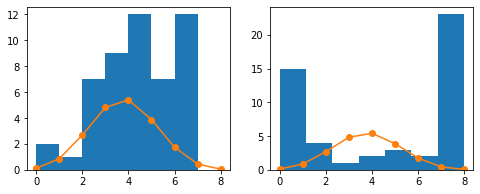

In [182]:
q_small = 1 / (1 + np.exp(s_small))
q_large = 1 / (1 + np.exp(s_large))

res_small = [np.random.binomial(8, i, 1)[0] for i in q_small]
res_large = [np.random.binomial(8, i, 1)[0] for i in q_large]

fig ,axes = plt.subplots(nrows=1, ncols=2, figsize=(4*2, 3))
axes[0].hist(res_small, bins=7);
axes[0].plot(y, predx4, '-o');

axes[1].hist(res_large, bins=7, align='mid');
axes[1].plot(y, predx4, '-o');

#### 線形予測子の構成要素：固定効果とランダム効果
統計モデルに線形予測子が含まれている場合、その構成要素は固定効果とランダム効果に分類される。  
線形予測子に固定効果とランダム効果のあらわす項をもっているので、そのようなGLMは混合モデル、あるいは混合効果モデルと呼ばれる。

### 7.4 一般化線形混合モデルの最尤推定
GLMMに含まれている個体差$r_i$は最尤推定できない。  
100個分の生存データ$y_i$を説明するために100個のパラメータ$\{r_1,r_2,\cdots,r_{100} \}$の値を最尤推定するのはフルモデルとなるからである。  
この場合の対処法として、ここでは個体ごとの尤度$L_i$の式の中で、$r_i$を積分する方法がある。
$$
L_i=\int_{-\infty}^{+\infty}p(y_i|\beta_1,\beta_2,r_i)p(r_i|s)dr_i
$$

こうすることで尤度から$r_i$は消える。  
$p(r_i|s)$で重みづけした期待値となっている。  
この操作は2種類の分布を混ぜていることに相当する。

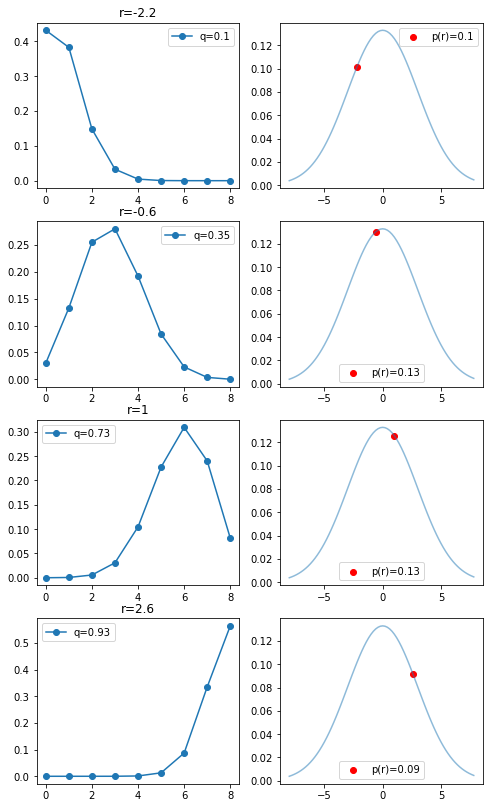

In [275]:
fig ,axes = plt.subplots(nrows=4, ncols=2, figsize=(4*2, 3.5*4))

for ax, r in zip(axes, [-2.2,-0.6,1,2.6]):
    y = np.arange(0, 9)
    p = logistic(r)
    ax[0].set_title('r='+str(r))
    ax[0].plot(binom.pmf(k=y, n=8, p=p), '-o', label='q='+str(np.round(p,2)))
    ax[0].legend()
    
    x_norm = np.arange(-8, 8, 0.2)
    pr = norm.pdf(r, loc=0, scale=3)
    ax[1].plot(x_norm, norm.pdf(x_norm, loc=0, scale=3), alpha=.5)
    ax[1].scatter(r, pr, color='red', label='p(r)='+str(np.round(pr, 2)))
    ax[1].legend()

これらを足し合わせて混合された分布は次のようになる。

In [256]:
mix = np.zeros(9)
for r in np.arange(-100,100):
    y = np.arange(0, 9)
    p = logistic(r)
    bi = binom.pmf(k=y, n=8, p=p)
    pr = norm.pdf(r, loc=0, scale=3)
    mix += bi*pr

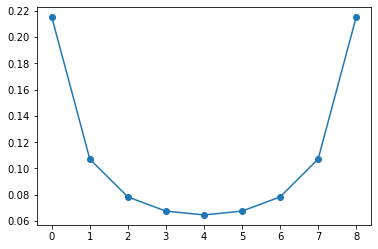

In [257]:
plt.plot(mix, '-o');

次にポアソン分布での例を示す。

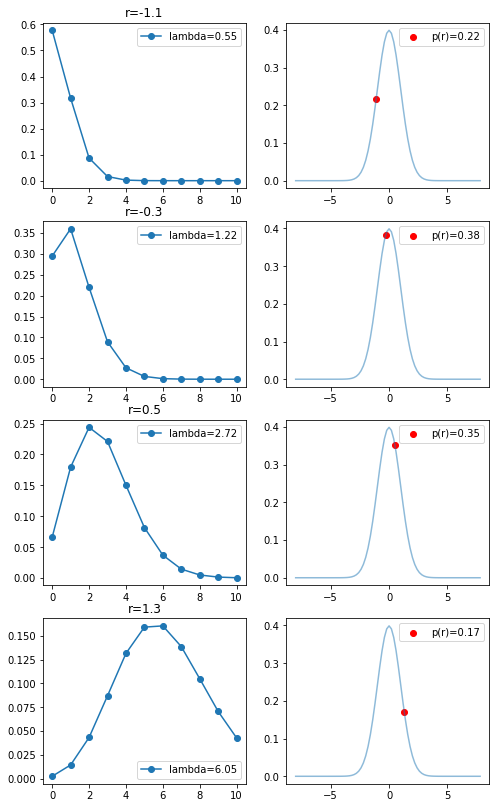

In [274]:
from scipy.stats import poisson

fig ,axes = plt.subplots(nrows=4, ncols=2, figsize=(4*2, 3.5*4))

for ax, r in zip(axes, [-1.1,-0.3,0.5,1.3]):
    y = np.arange(0, 11)
    lmd = np.exp(0.5+r)
    ax[0].set_title('r='+str(r))
    ax[0].plot(poisson.pmf(k=y, mu=lmd), '-o', label='lambda='+str(np.round(lmd,2)))
    ax[0].legend()
    
    x_norm = np.arange(-8, 8, 0.2)
    pr = norm.pdf(r, loc=0, scale=1)
    ax[1].plot(x_norm, norm.pdf(x_norm, loc=0, scale=1), alpha=.5)
    ax[1].scatter(r, pr, color='red', label='p(r)='+str(np.round(pr, 2)))
    ax[1].legend()

In [272]:
mix2 = np.zeros(11)
for r in np.arange(-100,100):
    y = np.arange(0, 11)
    lmd = np.exp(0.5+r)
    poi = poisson.pmf(k=y, mu=lmd)
    pr = norm.pdf(r, loc=0, scale=1)
    mix2 += poi*pr

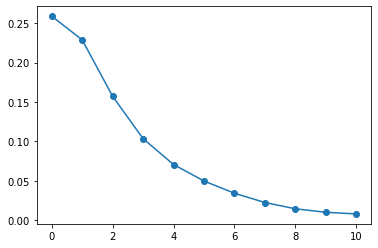

In [273]:
plt.plot(mix2, '-o');

全体の尤度は、
$$
L(\beta_1,\beta_2,s)=\prod_iL_i
$$
となる。  
対数尤度$\log{L}(\beta_1,\beta_2,s)$が最大になるような、パラメータ$\beta_1,\beta_2,s$の最尤推定値を探し出すこととなる。

### 7.5 現実のデータ解析にはGLMMが必要
GLMMのような考え方が必要になるかどうかの判断のポイントは、  
「同じ個体・場所などから何度もサンプリングしているか」あるいは  
「個体差や場所差が識別できてしまうようなデータのとりかたをしているか」といったところにある。  

#### 反復・疑似反復と統計モデルの関係
個体差・場所差をどのように統計モデルに組み込むには「データをどのようにとったか」に依存している。  
個体差・場所差が「見えてしまう」データのとりかたをしているかどうかである。

種子の生存確率を知るために、植物から種子をとってきてその生死を調査したとする。  
この植物は植木鉢で育てられているとする。  
各個体でひとつだけ種子の生死を調べているので、過分散も生じなければ個体差のばらつきも推定できない。  
ひとつの植木鉢に1個体がいるだけなので、個体差と植木鉢差の区別ができない。  
このようなデータの取り方では、GLMMは使えず、$logit(q_i)=\beta_1+\beta_2x_i$と指定するGLMで推定して問題ない。  
このようなデータと取り方は**反復**と呼ぶ。  
同じ個体から採取した$N$個の種子の生死を調べた場合には、個体差をいれたGLMMを使えば「個体差のばらつき」sが推定される。
このような「個体から複数データをとる」という実験操作は、**疑似反復**と呼ぶ。  
個体差さ推定可能な場合は、統計モデルに$logit(q_i)=\beta_1+\beta_2x_i+r_i$と、個体差$r_i$を明示的に組み込まれなければならない。  
  
植木鉢に複数の個体が植えられている場合、植木鉢に関して疑似反復となっており、  
植木鉢の効果を$r_j$としたとき、$logit(q_i)=\beta_1+\beta_2x_i+r_j$となるGLMMで推定しなければならない。  
個体も植木鉢も疑似反復の場合は、$logit(q_i)=\beta_1+\beta_2x_i+r_i+r_j$と指定しなければならない。  